In [1]:
import cartopy.crs as ccrs
import hvplot.xarray
import xarray as xr
import requests
from glob import glob
import pandas as pd
from herbie import Herbie
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map
wave_wind_mapping = {
    # Combined Wave Parameters
    "Hsig": "HTSGW",       # Hsig: Significant wave height -> HTSGW: Significant Height of Combined Wind Waves and Swell
    "PkDir": "DIRPW",      # PkDir: Peak wave direction -> DIRPW: Direction of Combined Wind Waves and Swell (Often peak direction is reported as the primary direction)
    "Tm01": "PERPW",       # Tm01: Mean wave period (m01) -> PERPW: Mean Period of Combined Wind Waves and Swell (Tm01 is a common representation for mean period)
    # Wind Parameters
    #"Windv_x": "UGRD",     # Windv_x: Horizontal component of wind velocity -> UGRD: U-component of wind
    #"Windv_y": "VGRD",     # Windv_y: Vertical component of wind velocity (Likely intended as the other horizontal component) -> VGRD: V-component of wind
}

In [49]:
def download_GEFS(date):
    try:
        dsets = []
        for fxx in [0, 3, 6, 9, 12, 15, 18, 21]:
            H = Herbie(date, model="gefs", product="wave", member="p01", fxx=fxx, save_dir="./GEFS", verbose=True)
            ds = H.xarray(rf":(?:HTSGW|DIRPW|PERPW):surface:(?:anl|(?:3|6|9|12|15|18|21) hour fcst)", remove_grib=True, backend_kwargs=dict(decode_timedelta=False))
            ds = ds.sel(longitude=slice(165, 180), latitude=slice(-33,-48))
            ds = ds.drop_vars("time").rename({"step": "time"}).assign_coords(time=ds.valid_time.values).drop_vars(["gribfile_projection", "surface", "valid_time"])
            dsets.append(ds)
        dsets = xr.concat(dsets, dim="time")
        return dsets
    except:
        print(f"Failed to download data for {date}")
        return None
ds = download_GEFS("2023-10-01")
ds

✅ Found ┊ model=gefs ┊ product=wave ┊ 2023-Oct-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [GEFS/gefs/20231001]
✅ Found ┊ model=gefs ┊ product=wave ┊ 2023-Oct-01 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=wave ┊ 2023-Oct-01 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=wave ┊ 2023-Oct-01 00:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=wave ┊ 2023-Oct-01 00:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=wave ┊ 2023-Oct-01 00:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=wave ┊ 2023-Oct-01 00:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=wave ┊ 2023-Oct-01 00:00 UTC F21 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 352kB
Dimensions:    (time: 8, latitude: 61, longitude: 60)
Coordinates:
  * time       (time) datetime64[ns] 64B 2023-10-01 ... 2023-10-01T21:00:00
  * latitude   (latitude) float64 488B -33.0 -33.25 -33.5 ... -47.5 -47.75 -48.0
  * longitude  (longitude) float64 480B 165.0 165.3 165.5 ... 179.3 179.5 179.8
Data variables:
    swh        (time, latitude, longitude) float32 117kB 3.38 3.44 ... 3.88 3.91
    dirpw      (time, latitude, longitude) float32 117kB 211.7 211.8 ... 240.2
    perpw      (time, latitude, longitude) float32 117kB 13.54 13.58 ... 13.19
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   gefs
    product:                 wave
    description:             Global Ensemble Forecast System (GEFS)
    remote_grib:             https://noaa-gefs-pds.s3.amazonaws.com/gefs.2023...
    local_grib:              GEFS/gefs/20231001/subset_35efd2bc__gefs.wave.t0...
    search:                  :(?:HTSGW|DIRPW|PERPW):surface:(?:anl|(?:3|6|9|1...

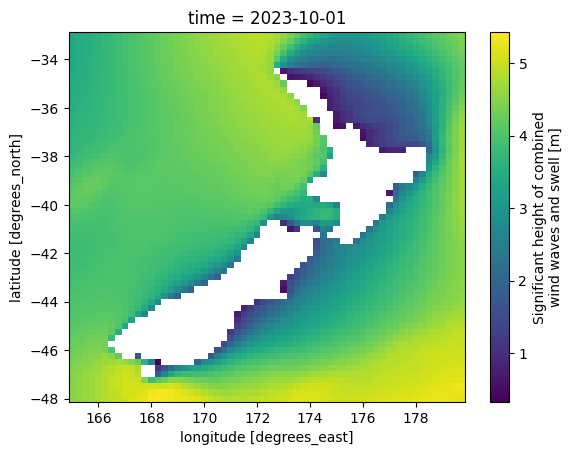

In [51]:
ds.swh[0].plot()

In [52]:
ds.swh.hvplot(
    groupby="time",
    widget_type="scrubber",
    widget_location="bottom",
    clim=(0, 4.5),
    width=500,
    cmap="spectral_r",
    geo=True,
    coastline=True
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'fc404ed2-11ff-445e-90bf-b639f2d9c438': {'version…